## Scientific Publications Data Warehouse

Project 1: A Data Cube on top of Delta Lake (ETL)
#### *Purpose*
The purpose is to extract data about scientific publications from JSON data that describe, title, topic, authors, etc., about a large number of papers and populate a data warehouse to issue analytics queries using SQL.

We will use Spark DataFrames to extract and transform the data.

We will also use Spark tables (delta tables) to be used for dimensions and fact tables as will be shown below.

### *DWH Schema*

We will follow the proposed schema as shown:

DBLP Fact Table:
    - Date_ID (FK)
    - Keyword_ID (FK)
    - Type_ID (FK)
    - Publication_ID (FK)
    - Venue_ID (FK)
    - FOS_ID (FK)
    - ORG_ID (FK)
    - Author_ID (FK)
    - Lange_ID (FK)
    - AuthorRank

Keyword Table:
    - ID
    - Text

Type Table:
    - ID
    - Description

Publication Table:
    - ID
    - Title
    - Year
    - PageStart
    - PageEnd
    - DOI
    - PDF
    - URL
    - Abstract
    - IndexedAbstract
    - N_Citation

Venue Table:
    - ID
    - Name
    - City
    - Country

Date Table:
    - ID
    - Year
    - Month
    - Day

Language Table:
    - ID
    - Name

FOS Table:
    - ID
    - Field

ORG Table:
    - ID
    - Name
    - City
    - Country

Author Table:
    - ID
    - FirstName
    - LastName
    - MiddleName


### *Dataset*

The data source is https://www.aminer.org/citation, version 13, as it is the most detailed one in JSON
format. You can also check the schema of the respective data set on the same page under the  "Description" link – note that the schema may not correspond to the schema in the JSON file.


#### Dataschema of V13

_Backed to v11 schema, where id and references are in String form._*


| --- | --- | --- | ---
| Field Name | Field Type | Description | Example
| id | string | paper ID | 43e17f5b20f7dfbc07e8ac6e
| title | string | paper title | Data mining: concepts and techniques
| authors.name | string | author name | Jiawei Han
| authors.org | string | author affiliation | Department of Computer Science, University of Illinois at Urbana-Champaign
| authors.id | string | author ID | 53f42f36dabfaedce54dcd0c
| venue.id | string | paper venue ID | 53e17f5b20f7dfbc07e8ac6e
| venue.raw | string | paper venue name | Inteligencia Artificial, Revista Iberoamericana de Inteligencia Artificial
| year | int | published year | 2000
| keywords | list of strings | keywords | ["data mining", "structured data", "world wide web", "social network", "relational data"]
| fos.name | string | paper fields of study | Web mining
| fos.w | float | fields of study weight | 0.659690857
| references | list of strings | paper references | ["4909282", "16018031", "16159250",  "19838944", ...]
| n_citation | int | citation number | 40829
| page_start | string | page start | 11
| page_end | string | page end | 18
| doc_type | string | paper type: journal, book title... | book
| lang | string | detected language | en
| publisher | string | publisher | Elsevier
| volume | string | volume | 10
| issue | string | issue | 29
| issn | string | issn | 0020-7136
| isbn | string | isbn | 1-55860-489-8
| doi | string | doi | 10.4114/ia.v10i29.873
| pdf | string | pdf URL | //static.aminer.org/upload/pdf/1254/ 370/239/53e9ab9eb7602d970354a97e.pdf
| url | list | external links | ["http://dx.doi.org/10.4114/ia.v10i29.873", "http://polar.lsi.uned.es/revista/index.php/ia/ article/view/479"]
| abstract | string | abstract | Our ability to generate...
| indexed_abstract | dict | indexed abstract | {"IndexLength": 164, "InvertedIndex": {"Our": [0], "ability": [1], "to": [2, 7, ...]}}

### Extract

In [1]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [2]:
# let's fetch the data
# !wget https://originalstatic.aminer.cn/misc/dblp.v13.7z
# !7z x dblp.v13.7z


In [3]:
%pip install gender_guesser
%pip install requests

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
# we will read and process the data while cleaning it simultaneously

import json
import ast
import os
# import tqdm.notebook

def process_json(file_name, split_size, output_prefix, offset=0, file_number=0):
    with open(file_name, 'r', encoding='utf-8') as ifh:
        # seek to the second line in the file
        if offset > 0:
            ifh.seek(offset)
        else:
            ifh.seek(1) # skip the first '['
        file_number = file_number
        checkpoint = []
        file_sizes = []
        end_of_file = False
        # we will keep looping until all the lines are read
        while not ifh or not end_of_file:
            file_number += 1
            # json_objects = [ast.literal_eval(build_json_object(ifh)) for _ in tqdm.notebook.tqdm(range(split_size))]
            json_objects = []
            while len(json_objects) < split_size:
                try:
                    json_objects.append(ast.literal_eval(build_json_object(ifh)))
                except:
                    end_of_file = True
                    break # we reached the end of the file
            print(f"Checkpoint {file_number}: {ifh.tell()}, objects processed: {len(json_objects)}")
            # write each json object to a file
            with open(f"{output_prefix}{file_number}.json", 'w', encoding='utf-8') as ofh:
                # this process yields smaller files than using json.dump w/ indent = 4
                for i, json_object in enumerate(json_objects):
                    if i == len(json_objects) - 1:
                        ofh.write(json.dumps(json_object) + "]")
                    elif i == 0:
                        ofh.write('[' + json.dumps(json_object) + ",")
                    else:
                        ofh.write(json.dumps(json_object[0]) + ",")
            # get the size of the file
            file_sizes.append(os.path.getsize(f"{output_prefix}{file_number}.json") / 1024 / 1024)
            checkpoint.append(ifh.tell())
            print(f"Checkpoint {file_number}: {checkpoint[-1]}, objects processed: {len(json_objects)}, size of file {file_number}: {file_sizes[-1]} MB")
            # break # for testing purposes
        print(f"Finished processing {file_name}, {file_number} files created.")
        return checkpoint, file_sizes

def clean_line(line):
    if "NumberInt" in line:
        line = line.replace("NumberInt", "") # NumberInt(123) -> (123)
        line = line.replace("(", '"') # (123) -> "123)
        line = line.replace(")", '"') # "123) -> "123"
    if ": null," in line or ": null" in line:
        line = line.replace("null", '""')
    return line

def build_json_object(fh):
    buffer = ''
    line = fh.readline()
    while line != "},\n":
        if not line:
            print("Reached end of file")
            return buffer[:-2]
        buffer += clean_line(line)
        line = fh.readline()
    buffer += line
    return buffer


In [5]:
# results = process_json('dblpv13.json', 100000, 'clean_dataset/dblpv13_clean_', offset=17260419910, file_number=53)
# results = process_json('dblpv13.json', 100000, 'clean_dataset/dblpv13_clean_')

### Transform

Here we will begin the transformation part of our pipeline. We will use delta tables and pyspark dataframes to do this. There are a few tasks that we must complete:
1. Drop publications with very short titles (one word, empty authors, etc.)
2. Visualize the number of citations
3. ISSN is sometimes filled with wrong values, we can either drop or make an effor to resolve using DOI for instance.
4. Defining the type of publication (journal, book, conference, etc.)
5. Resolving ambiguous author names
6. Resolving ambiguous or abbreviated conference and journal names using DBLP database.
7. Refining venues
8. Author gender
9. H-index of authors
10. Normalization of the field of study

In [6]:
from pyspark.sql import SparkSession

import warnings
warnings.filterwarnings("ignore")


In [7]:
path_to_data = 'clean_dataset/dblpv13_cleanv2_'

In [8]:
# change the memory size depending
spark = SparkSession.builder \
    .appName("Project1") \
    .config("spark.jars.packages", "io.delta:delta-core_2.12:2.1.0") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .config("spark.sql.warehouse.dir", "file:///tmp/spark-warehouse")\
    .config("spark.driver.memory", "16g")\
    .config("spark.executor.memory", "16g")\
    .config("spark.driver.maxResultSize", "16g")\
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
    .getOrCreate()

In [9]:
# gender
# %pip install gender_guesser
import gender_guesser.detector as gender

def get_author_gender(first_name):
    d = gender.Detector()
    gender_result = d.get_gender(first_name)
    if gender_result == "mostly_male":
        return "male"
    elif gender_result == "mostly_female":
        return "female"
    else:
        return gender_result

# with api / has limit
# import request
# def get_author_gender(first_name):
#     url = f'https://api.genderize.io/?name={first_name}'
#     response = requests.get(url)
#     if response.status_code == 200:
#         data = response.json()
#         if 'gender' in data:
#             return data['gender']
#     return None

def add_author_gender(authors):
    genders = []
    for author in authors:
        if author is None:
            return None
        gender = get_author_gender(author.split()[0])
        genders.append(gender)
    return genders

In [10]:
# author names
import requests

def resolve_names(name):
    response = requests.get("https://dblp.org/search/author/api", params={"q": name, "format": "json"})
    if response.status_code == 200:
        result = response.json()
        if "result" in result and "hits" in result["result"]:
            if "hit" in result["result"]["hits"]:
                for hit in result["result"]["hits"]:
                    if "info" in hit and "author" in hit["info"]:
                        author_name = hit["info"]["author"]
#                     if author_name.lower() == name.lower():
                        return author_name
    return name


def add_resolved_names(authors):
    names = []
    for author in authors:
        name = resolve_names(author['name'])
        names.append(name)
    return names

In [11]:
# publ titles, venues
import requests

def resolve_data(request):
    response = requests.get("https://dblp.org/search/publ/api", params={"q": request, "format": "json"})
    if response.status_code == 200:
        result = response.json()
        if "result" in result and "hits" in result["result"]:
            hits = result["result"]["hits"]
            if "hit" in hits:
                for hit in hits["hit"]:
                    if all(key in hit["info"] for key in ["title", "venue"]):
                        resolved_data = hit["info"]["title"]
                        refined_venue = hit["info"]["venue"]
                        return (resolved_data, refined_venue)
    
    return (None, None)

In [12]:
%pip install spacy

Note: you may need to restart the kernel to use updated packages.


In [13]:
!python -m spacy download en_core_web_sm

                                              0.0/12.8 MB ? eta -:--:--
                                              0.0/12.8 MB 1.9 MB/s eta 0:00:07
                                              0.1/12.8 MB 907.3 kB/s eta 0:00:15
                                              0.1/12.8 MB 983.0 kB/s eta 0:00:13
                                              0.2/12.8 MB 1.4 MB/s eta 0:00:10
                                              0.3/12.8 MB 1.4 MB/s eta 0:00:10
     -                                        0.4/12.8 MB 1.5 MB/s eta 0:00:09
     -                                        0.4/12.8 MB 1.4 MB/s eta 0:00:09
     --                                       0.7/12.8 MB 1.9 MB/s eta 0:00:07
     --                                       0.8/12.8 MB 2.2 MB/s eta 0:00:06
     ---                                      1.2/12.8 MB 2.7 MB/s eta 0:00:05
     ----                                     1.4/12.8 MB 2.9 MB/s eta 0:00:04
     ----                                     1.4/12.8 

In [14]:
## resolve normalized foss
from typing import List
import spacy

nlp = spacy.load("en_core_web_sm")

normalized_fos = []

with open('normalized_fos.txt', 'r') as f:
    current_section = ''
    for line in f:
        line = line.strip()
        if line == '':
            continue
        cur_line = line.split(' ', 1)
        if cur_line[0].count('.') == 2:
            normalized_fos.append((cur_line[1]))

def resolve_nfos(fos: List[str]):
    if fos is None:
        return 'Other'
    similarities = [(n_fos, nlp(','.join(fos)).similarity(nlp(n_fos))) for n_fos in normalized_fos]
    return max(similarities, key= lambda x: x[1])[0]


In [15]:
# calculate h-index


def calc_h_index(citations):
    if citations is None or len(citations) == 0:
        return 0
    citations.sort(reverse=True)
    h_index = 0
    for i, citation in enumerate(citations):
        if citation >= i + 1:
            h_index = i + 1
        else:
            break
    return h_index

In [16]:
from pyspark.sql.functions import explode, col, length, udf, StructType, StringType, struct, when, lit, collect_list
from pyspark.sql.types import IntegerType, StructField
from pyspark.sql.window import Window


# Function to merge two schemas
def merge_schemas(schema1, schema2):
    merged_fields = {field.name: field for field in schema1}
    for field in schema2:
        if field.name not in merged_fields:
            merged_fields[field.name] = field
    return StructType(sorted(merged_fields.values(), key=lambda field: field.name))

  
def preprocess_dataframe(df):
    df = df.dropDuplicates()
    
    # 1. Drop publications with very short titles (one word, empty authors, etc.)
    df = df.filter(df.title.isNotNull()) \
        .filter(length(df.title) > 5) \
        .filter(col('title').contains(' '))\
        .filter(~df.title.rlike(".*Editorial.*")) \
        .filter(~df.title.rlike(".*Forward.*")) \
        .filter(~df.title.rlike(".*Preface.*")) \
        .filter(~df.title.rlike(".*Conference.*")) \
        .filter(~df.title.rlike(".*Proceedings.*")) \
        .filter(~df.title.rlike(".*Symposium.*")) \
        .filter(~df.title.rlike(".*Workshop.*")) \
        .filter(~df.title.rlike(".*Tutorial.*")) \
        .filter(~df.title.rlike(".*Forum.*"))

    df = df.filter(length(df.abstract) > 0)

    df = df.filter(df.issn.isNotNull()) \
        .filter(length(df.issn) > 5)
    
    # 2. Visualize the number of citations
    df = df.withColumn("n_citation_int", col("n_citation").cast("integer"))
    
    # 3. ISSN is sometimes filled with wrong values, we can either drop or make an effor to resolve using DOI for instance.
    df = df.filter(~df.doi.rlike(".*[a-zA-Z]+.*"))
    
    
    # 4. Defining the type of publication (journal, book, conference, etc.)
    df = df.withColumn('pub_type', lit('Conference'))
    df = df.withColumn('pub_type', when(col('venue.raw').contains('@'), 'Workshop')
                                   .when((col('volume') != '') | (col('issue') != ''), 'Journal')
                                   .otherwise(col('pub_type')))
    
    # 5. Resolving ambiguous author names
    resolve_name_udf = udf(add_resolved_names, StringType())
    df = df.withColumn("resolved_authors", resolve_name_udf(df.authors))
    
    # 6. Resolving ambiguous or abbreviated conference and journal names using DBLP database
    # 7. Refining venues
    resolve_data_udf = udf(resolve_data, StructType([StructField("title", StringType()), StructField("venue", StringType())]))

    df = df.withColumn("resolved_data", resolve_data_udf(df.title))
    df = df.withColumn("resolved_title", df.resolved_data.title)
    df = df.filter(col("resolved_title").isNotNull())
    df = df.withColumn("refined_venue", df.resolved_data.venue)
    df = df.drop("resolved_data")

    # 8. Author gender
    get_author_gender_udf = udf(add_author_gender, StringType())
    df = df.withColumn('authors_gender', get_author_gender_udf(df.resolved_authors))
    
    # 9. h index
    calc_h_index_udf = udf(calc_h_index, IntegerType())

    # exploded author
    dfa = df.withColumn('author', explode(df.authors))

    # authors with h indexes
    a_h = dfa.groupBy(dfa.author).agg(collect_list(dfa.n_citation_int).alias('citations'))
    a_h = a_h.withColumn('author_h_index', calc_h_index_udf(a_h.citations))
    
    joined_df = dfa.join(a_h, ['author'], 'left')

    joined_df = joined_df.drop('authors')

    result_df = joined_df.select('*').groupBy('author', 'author_h_index').agg(struct(
            "author._id", "author.bio", "author.email", "author.gid", "author.name", "author.name_zh", "author.oid", "author.oid_zh",
            "author.orcid", "author.org", "author.org_zh", "author.orgid", "author.orgs", "author.orgs_zh", "author.sid",
            "author_h_index"  # add author_h_index as part of the struct
        ).alias("authors"))
    
    result_df = result_df.drop('author_h_index')
    df = joined_df.join(result_df, ['author'])
    df = df.drop('author')

    # 10. normalized fos
    resolve_nfos_udf = udf(resolve_nfos, StringType())
    df = df.withColumn('nfos', resolve_nfos_udf('fos'))

    return df


In [17]:
# We read JSON files with schema inference and preprocess them
json_files = [f"{path_to_data}{i}.json" for i in range(1,2)]
dataframes = [preprocess_dataframe(spark.read.option("inferSchema", "true").json(file)) for file in json_files]

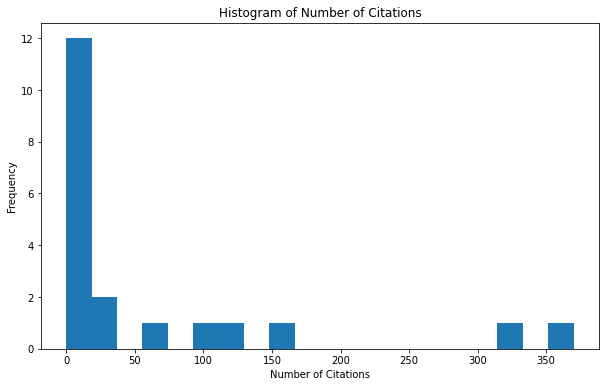

In [18]:
# 2. Visualize the number of citations
import matplotlib.pyplot as plt

citations_hist = dataframes[0].limit(20).select("n_citation_int").rdd.flatMap(lambda x: x).histogram(20)

citations_bins = citations_hist[0]
citations_counts = citations_hist[1]

plt.figure(figsize=(10, 6))

plt.hist(citations_bins[:-1], bins=citations_bins, weights=citations_counts)

plt.xlabel("Number of Citations")
plt.ylabel("Frequency")
plt.title("Histogram of Number of Citations")

plt.show()

In [19]:
merged_schema = dataframes[0].schema
for df in dataframes[1:]:
    merged_schema = merge_schemas(merged_schema, df.schema)

dataframes_with_merged_schema = [df.selectExpr(*merged_schema.fieldNames()) for df in dataframes]

combined_df = dataframes_with_merged_schema[0].limit(20)
for df in dataframes_with_merged_schema[1:]:
    combined_df = combined_df.unionByName(df.limit(20), allowMissingColumns=True)

combined_df.write.format("delta").mode("append").option("mergeSchema", "true").save("clean_dataset/delta/dblpv13")

Note: you may need to restart the kernel to use updated packages.


In [21]:
from pyspark.sql.functions import monotonically_increasing_id, year

combined_df = combined_df.withColumn("publication_id", monotonically_increasing_id()) \
    .withColumn("author_id", monotonically_increasing_id()) \
    .withColumn("venue_id", monotonically_increasing_id()) \
    .withColumn("fos_id", monotonically_increasing_id()) \
    .withColumn("org_id", monotonically_increasing_id()) \
    .withColumn("date_id", monotonically_increasing_id()) \
    .withColumn("keyword_id", monotonically_increasing_id()) \
    .withColumn("type_id", monotonically_increasing_id()) \
    .withColumn("lang_id", monotonically_increasing_id())

dblp_fact_table = combined_df.select("date_id", "keyword_id", "type_id", "publication_id", "venue_id",
                                      "fos_id", "org_id", "author_id", "lang_id")

keyword_table = combined_df.select("keyword_id",
                                   col("keywords").alias("text"))


venue_table = combined_df.select("venue_id",
                                 col("refined_venue").alias("name"),
                                 col("venue.type").alias("type"),
                                 col("venue.raw").alias("raw"),
                                 col("venue._id").alias("vid"))
venue_table = venue_table.filter(venue_table.type.isNotNull())

date_table = combined_df.select("date_id",
                                year("year").alias("year"))

language_table = combined_df.select("lang_id",
                                    col("lang").alias("name"))


fos_table = combined_df.select("fos_id",
                               col("nfos").alias("field"))

author_table = combined_df.select("author_id",
                                  col("resolved_authors").alias("name"),
                                  col("authors.org").alias("org"),
                                  col("authors.gid").alias("gid"),
                                  col("authors.orgid").alias("orgid"),
                                  col("authors_gender").alias("gender"),
                                  col("authors.author_h_index").alias("h_index"))

publication_table = combined_df.select("publication_id",
                                       col("resolved_title").alias("name"),
                                       col("abstract").alias("description"),
                                       col("doi").alias("doi"),
                                       col("issn").alias("issn"),
                                       col("isbn").alias("isbn"),
                                       col("url").alias("url"),
                                       col("pdf").alias("pdf"),
                                       col("page_start").alias("page_start"),
                                       col("page_end").alias("page_end"),
                                       col("volume").alias("volume"),
                                       col("issue").alias("issue"),
                                       col("n_citation").alias("n_citation"),
                                       col("pub_type").alias("pub_type"))


In [49]:
dblp_fact_table.write.format("delta").mode("append").save("clean_dataset/delta/dblp_fact_table")
keyword_table.write.format("delta").mode("append").save("clean_dataset/delta/keyword_table")
venue_table.write.format("delta").mode("append").save("clean_dataset/delta/venue_table")
date_table.write.format("delta").mode("append").save("clean_dataset/delta/date_table")
language_table.write.format("delta").mode("append").save("clean_dataset/delta/language_table")
fos_table.write.format("delta").mode("append").save("clean_dataset/delta/fos_table")
author_table.write.format("delta").mode("append").save("clean_dataset/delta/author_table")
publication_table.write.format("delta").mode("append").save("clean_dataset/delta/publication_table")


In [ ]:
# load table from delta lake
dblp_fact_table = spark.read.format("delta").load("clean_dataset/delta/dblp_fact_table")
venue_table = spark.read.format("delta").load("clean_dataset/delta/venue_table")
keyword_table = spark.read.format("delta").load("clean_dataset/delta/keyword_table")
date_table = spark.read.format("delta").load("clean_dataset/delta/date_table")
language_table = spark.read.format("delta").load("clean_dataset/delta/language_table")
fos_table = spark.read.format("delta").load("clean_dataset/delta/fos_table")
author_table = spark.read.format("delta").load("clean_dataset/delta/author_table")
publication_table = spark.read.format("delta").load("clean_dataset/delta/publication_table")


In [22]:
display(venue_table)

venue_id,name,type,raw,vid
0,IEEE Trans. Learn. Technol.,0,J. High Speed Networks,555036c17cea80f9541516a0
1,Int. J. Inf. Sec.,2,Information Processing and Management of Uncertainty,53e18c8d20f7dfbc07e9024f
2,Eng. Appl. Artif. Intell.,0,Pattern Recognition,539e72778314ff4cf49b3f5d
3,BMC Bioinform.,0,BMC Bioinformatics,54826079582fc50b5e20fe5b
4,IEEE Trans. Learn. Technol.,0,European Transactions on Telecommunications,53a7321620f7420be8d78ece
5,IEEE Trans. Very Large Scale Integr. Syst.,0,IEEE Trans. VLSI Syst.,555036cf7cea80f954158d42
6,CIS,0,CIS,53a72ec720f7420be8c9a9e3
8,Pacific Symposium on Biocomputing,0,Pacific Symposium on Biocomputing,53a7254520f7420be8b4a58f
9,CGVC,0,ACM Trans. Graph.,555036f67cea80f95416a9f4
10,J. Symb. Log.,0,"J. Comb. Theory, Ser. B",555036df7cea80f954162774


In [38]:
%pip install graphframes

                                              0.0/154.7 kB ? eta -:--:--
     -------                                  30.7/154.7 kB 1.4 MB/s eta 0:00:01
     ----------                               41.0/154.7 kB 330.3 kB/s eta 0:00:01
     -----------------------                  92.2/154.7 kB 585.1 kB/s eta 0:00:01
     ---------------------------------------  153.6/154.7 kB 706.2 kB/s eta 0:00:01
     ---------------------------------------- 154.7/154.7 kB 662.8 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [24]:
# Import necessary libraries
from graphframes import GraphFrame
from pyspark.sql.functions import collect_set, struct

In [25]:
# Join the author, dblp_fact, and publication tables
author_dblp_publication = author_table.join(
    dblp_fact_table, "author_id"
).join(publication_table, "publication_id")

In [27]:
co_authors = dblp_fact_table.alias('d1').join(
    dblp_fact_table.alias('d2'), "publication_id"
).filter('d1.author_id != d2.author_id').select(col('d1.author_id').alias('author1'), col('d2.author_id').alias('author2'), col('d2.publication_id').alias('publication'))

In [28]:
co_author_counts = (
    co_authors.groupby("author1", "author2")
    .agg({"publication": "count"})
    .withColumnRenamed("count(publication)", "co_author_count")
)

In [29]:
vertices = author_table.selectExpr("author_id as id", "name")

In [32]:
# Create the edges DataFrame from the co_author_counts table
edges = co_author_counts.selectExpr(
    "author1 as src", "author2 as dst", "co_author_count as weight"
)

In [ ]:
# Create the GraphFrame from the vertices and edges DataFrames
graph = GraphFrame(vertices, edges)